In [9]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

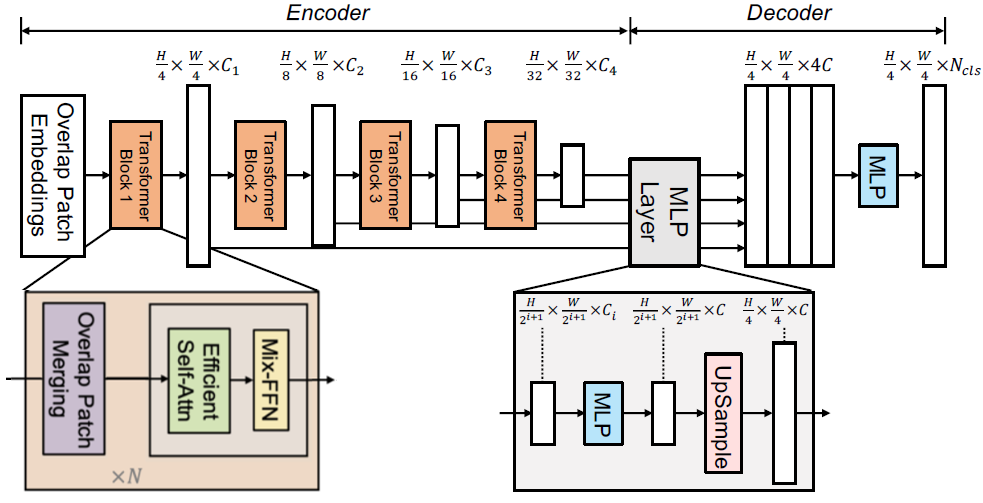

[Image reference](https://arxiv.org/abs/2105.15203)

In [10]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch

    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

In [11]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/archive.zip && unzip archive.zip

In [12]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/cityScapes_utils.py

In [13]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segformers.zip && unzip segformers.zip

In [14]:
# !mv segformers/* .

## 1. Dataset - CityScapes

In [15]:
targetWidth = 1024
targetHeight = 512

In [16]:
from utils import get_dataloaders
from cityScapes_utils import get_cs_datasets

train_set, val_set, test_set= get_cs_datasets(rootDir='')
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)#, batch_size=4)

There are 2380 train images, 595 validation images, 500 test Images
Input shape = torch.Size([3, 512, 1024]), output label shape = torch.Size([512, 1024])


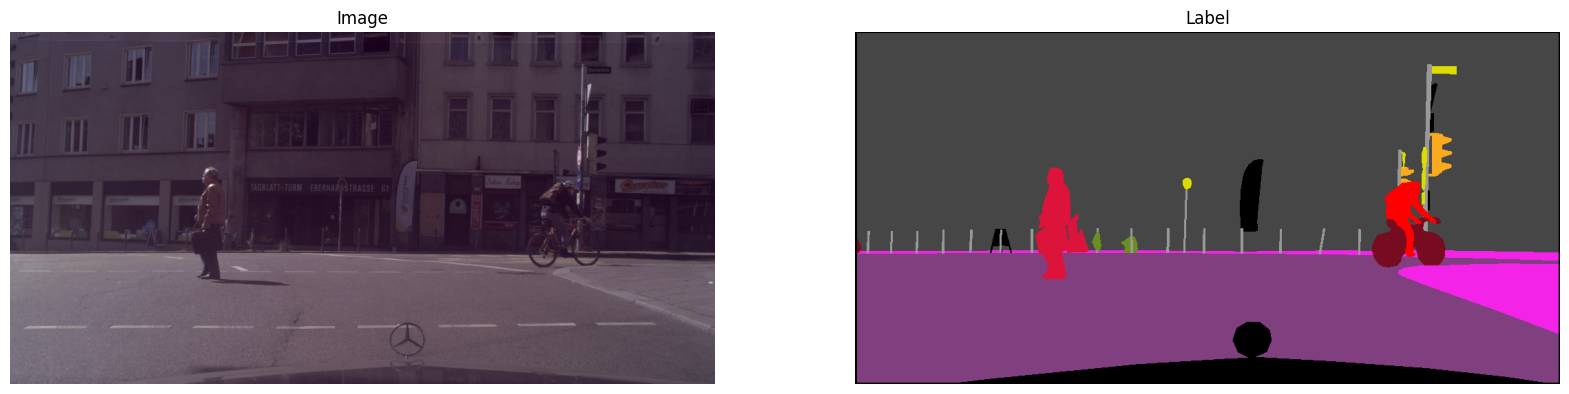

In [17]:
from utils import inverse_transform
from cityScapes_utils import train_id_to_color as cs_train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image)
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(cs_train_id_to_color[label])
axes[1].set_title("Label")
axes[1].axis('off')
plt.show()

## 2 — Segformer Network

### Mix Transformer / Encoder

*   Overlap Patch Embedding
*   Efficient Self-Attention
*   Mix FFNs


In [18]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, h, w

In [19]:
class efficient_self_attention(nn.Module):

    def __init__(self, attn_dim, num_heads, dropout, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, "attn_dim must be divisible by num_heads"
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.sr_ratio = sr_ratio  # spatial reduction ratio

        if self.sr_ratio > 1:
            self.sr = nn.Conv2d(in_channels=self.attn_dim, out_channels=self.attn_dim,
                                     kernel_size=self.sr_ratio, stride=self.sr_ratio)
            self.norm = nn.LayerNorm(self.attn_dim)

        # Query, Key, Value projections for all the heads
        self.q = nn.Linear(self.attn_dim, self.attn_dim, bias=True)
        self.kv = nn.Linear(self.attn_dim, 2 * self.attn_dim, bias=True)
        # Scaled by the root of head dimension
        self.scale = (self.attn_dim // self.num_heads) ** -0.5  # like doing 1 / sqrt()
        # Projecting concatenated output back to attn_dim
        self.proj = nn.Linear(self.attn_dim, self.attn_dim)

    def forward(self, x, h, w):
        Q = self.q(x)
        Q = rearrange(Q, 'b hw (n c) -> b n hw c', n=self.num_heads)

        if self.sr_ratio > 1:
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = self.sr(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            x = self.norm(x)

        K, V = self.kv(x).chunk(2, dim=-1)

        K = rearrange(K, 'b hw (n c) -> b n hw c', n=self.num_heads)
        V = rearrange(V, 'b hw (n c) -> b n hw c', n=self.num_heads)

        # Q, K, V are of shape (batch_size, num_heads, seq_len, head_dim)
        attn = torch.einsum('b n i c, b n j c -> b n i j', Q, K) * self.scale
        attn = attn.softmax(dim=-1)

        x = torch.einsum('b n i j, b n j c -> b n i c', attn, V)

        x = rearrange(x, 'b n hw c -> b hw (n c)')

        x = self.proj(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [20]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)

        # Depth-wise separable convolution
        self.conv = nn.Conv2d(hidden_features, hidden_features, (3, 3), padding=(1, 1),
                              bias=True, groups=hidden_features)
        self.dropout_p = dropout_p

    def forward(self, x, h, w):
        x = self.fc1(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.conv(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = F.gelu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x

In [21]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout, drop_path, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.dim = dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.drop_path = drop_path
        self.sr_ratio = sr_ratio
        self.attn = efficient_self_attention(attn_dim=self.dim, num_heads=self.num_heads,
                                             dropout=self.dropout, sr_ratio=self.sr_ratio)
        self.ffn = mix_feedforward(in_features=self.dim, out_features=self.dim,
                                   dropout_p=self.dropout, hidden_features=self.dim * 4)
        self.norm1 = nn.LayerNorm(self.dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(self.dim, eps=1e-6)

    def forward(self, x, h, w):
        x = x + self.attn(self.norm1(x), h, w)
        # x = drop_path(x, self.drop_path, self.training)
        x = x + self.ffn(self.norm2(x), h, w)
        # x = drop_path(x, self.drop_path, self.training)
        return x

In [22]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = nn.ModuleList(blocks)
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

## Mix Transformer Encoder

In [23]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths,
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm

            blocks = []
            for i in range(depths[stage_i]):
                blocks.append(transformer_block(dim=embed_dims[stage_i], num_heads=num_heads[stage_i],
                                                dropout=dropout_p,sr_ratio=sr_ratios[stage_i],
                                                drop_path=drop_path_p * (sum(depths[:stage_i])+i) / (sum(depths)-1)
                                                )
                              )

            if stage_i == 0:
                patch_size = 7
                stride = 4
                in_chans = in_chans
            else:
                patch_size = 3
                stride = 2
                in_chans = embed_dims[stage_i-1]

            patch_embed = overlap_patch_embed(in_chans=in_chans, embed_dim=embed_dims[stage_i],
                                              patch_size=patch_size, stride=stride)
            norm = nn.LayerNorm(embed_dims[stage_i], eps=1e-6)
            self.stages.append(mix_transformer_stage(patch_embed, blocks, norm))


    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

## Decoder Head

In [24]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(in_channels=ch, out_channels=self.embed_dim, kernel_size=(1, 1))
                                     for ch in reversed(self.in_channels)])
        self.linear_fuse = nn.Conv2d(in_channels=self.embed_dim * len(self.layers),
                                     out_channels=self.embed_dim,
                                     kernel_size=(1, 1), bias=False)
        self.bn = nn.BatchNorm2d(self.embed_dim, eps=1e-5)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, self.num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]

        # project each encoder stage output to H/4, W/4
        x = [layer(xi) for layer, xi in zip(self.layers, reversed(x))]
        x = [F.interpolate(xi, size=feature_size, mode='bilinear', align_corners=False)
             for xi in x[:-1]] + [x[-1]]

        # concatenate project output and use 1x1
        # convs to get num_class channel output
        x = torch.cat(x, dim=1)
        x = self.linear_fuse(x)
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.linear_pred(x)

        return x

## Segformer

In [25]:
class segformer_mit_b3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512),
                                        num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                        sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512),
                                           num_classes=num_classes, embed_dim=256)

        # init weights
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")


    def forward(self, x):
        image_hw = x.shape[2:]
        x = self.backbone(x)
        x = self.decoder_head(x)
        x = F.interpolate(x, size=image_hw, mode='bilinear', align_corners=False)
        return x

In [26]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 15
NUM_CLASSES = 19
MAX_LR = 1e-3
MODEL_NAME = f'segformer_mit_b3_cs_pretrain_19CLS_{targetHeight}_{targetWidth}_CE_loss'
output_path = 'dataset'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
# criterion = smp.losses.DiceLoss('multiclass', classes=np.arange(20).tolist(), log_loss = True, smooth=1.0)
criterion = nn.CrossEntropyLoss(ignore_index=19)

# create model, load imagenet pretrained weights
model = segformer_mit_b3(in_channels=3, num_classes=NUM_CLASSES).to(device)
model.backbone.load_state_dict(torch.load('segformer_mit_b3_imagenet_weights.pt', map_location=device))

<All keys matched successfully>

In [28]:
# create optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR, betas=(0.9, 0.999), weight_decay=1e-4, amsgrad=False)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

Starting 1 epoch ...


100%|██████████| 595/595 [02:32<00:00,  3.90it/s]


Epoch: 1, trainLoss:0.84832, validationLoss:0.50821, meanIoU: 0.31
Starting 2 epoch ...


100%|██████████| 595/595 [02:22<00:00,  4.17it/s]


Epoch: 2, trainLoss:0.55605, validationLoss:0.88185, meanIoU: 0.24
Starting 3 epoch ...


100%|██████████| 595/595 [02:19<00:00,  4.27it/s]


Epoch: 3, trainLoss:0.51989, validationLoss:1.13932, meanIoU: 0.26
Starting 4 epoch ...


  9%|▉         | 224/2380 [01:38<15:45,  2.28it/s]


KeyboardInterrupt: 